# Artwork Recognition Dataset - surreal symphonies
## importing libraries 
    firstly we should import libraries which are necessary for the model to function and for other segments such as data processing , result visualization etc.

In [2]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image

# Pre-Trained Models
from tensorflow.keras.applications import InceptionV3, Xception, ResNet152V2, ResNet50V2, ResNet50


## Data Loading and Preprocessing
    we define the data_dir variable to specify the directory containing the image dataset. We then load the image dataset using tf.keras.preprocessing.image_dataset_from_directory function. Following that, we filter out any corrupted images from the dataset by iterating over each folder and deleting the corrupted images.

In [3]:
data_dir = '/kaggle/input/surreal-symphonies-a-dataset-of-diverse-art/Surreal Symphonies (A dataset of Diverse Artistic Visions)'

data = tf.keras.preprocessing.image_dataset_from_directory(data_dir)

Found 7315 files belonging to 30 classes.


In [43]:
# Iterate through the dataset directory and print the class names
for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        print(class_name)

Minimalism art
Pop art
Romanticism paintings
Symbolism artwork
Digital art
Mannerism paintings
Neoclassical art
Academic art
Art deco paintings
Impressionism artwork
Baroque paintings
Fauvism paintings
Abstract art
Expressionism paintings
Realism paintings
Pre-Raphaelite paintings
Surrealism artwork
Dadaism artwork
Neo-expressionism art
Modernism artwork
Na�ve art
Constructivism art
Post-impressionism artwork
Contemporary art
Art Nouveau paintings
Gothic art
Renaissance paintings
Surrealist paintings
Cubism art
Abstract expressionism paintings


## Data Augmentation and Generator
    In this segment, we create an ImageDataGenerator object datagen for data augmentation. The datagen is configured with various augmentation parameters such as rotation, width and height shift, shear, zoom, and horizontal flip. The images are also rescaled by dividing by 255. We then specify the image dimensions, batch size, and image shape. Finally, we create separate data generators for training and validation using the flow_from_directory method, which loads the images from the specified directory, performs data augmentation, and provides the images and their corresponding labels.

In [6]:
# Create an ImageDataGenerator and do Image Augmentation
datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.2)

In [7]:
height = 228
width = 228
channels = 3
batch_size = 32
img_shape = (height, width, channels)
img_size = (height, width)

In [8]:

train_data = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

val_data = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')


Found 5837 images belonging to 30 classes.
Found 1445 images belonging to 30 classes.


In [9]:

num_classes = len(data.class_names)
print('.... Number of Classes : {0} ....'.format(num_classes))

.... Number of Classes : 30 ....


### image visualization

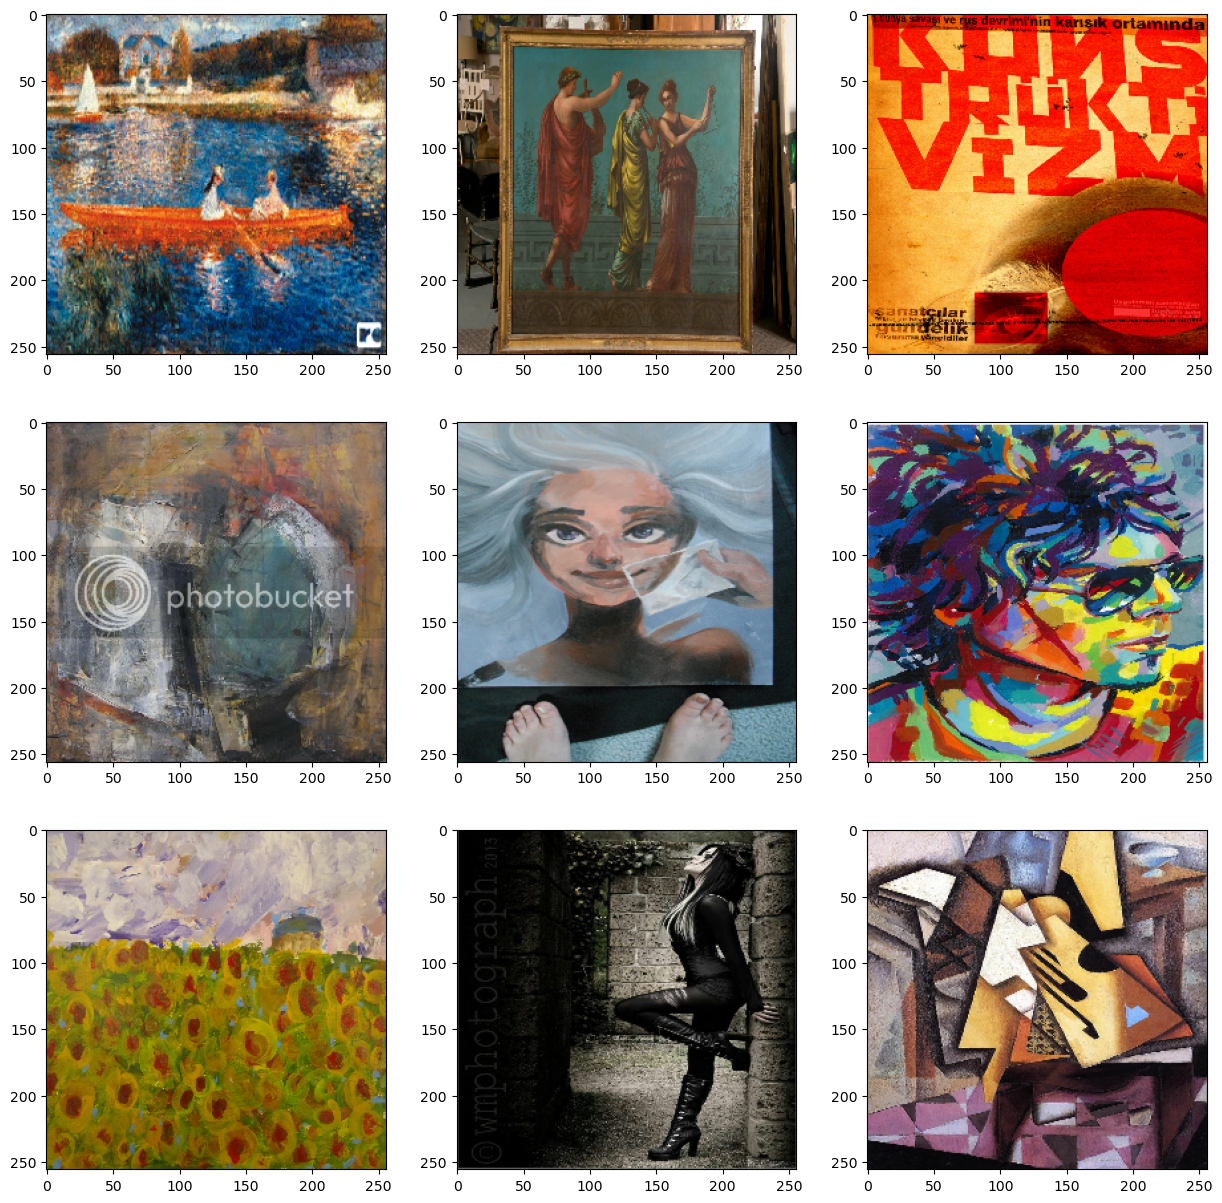

In [10]:

# Define a function to see images
def show_img(data):
    plt.figure(figsize=(15, 15))
    for images, labels in data.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            ax.imshow(images[i].numpy().astype("uint8"))
            ax.axis("on")

# Plot the images in the dataset
show_img(data)

## Training Model - InceptionV3

The code in this cell loads the pre-trained InceptionV3 model, freezes its layers, adds custom layers on top, and compiles the model.

The pre-trained VGG16 model is loaded using `tensorflow.keras.applications.InceptionV3` with the weights set to 'imagenet' and the fully connected layers excluded (`include_top=False`). The input shape and pooling type are specified as `img_shape` and 'avg' respectively.

Next, the code freezes the weights of all layers in the pre-trained model by setting their `trainable` attribute to `False`. This ensures that the pre-trained weights are not updated during training.

Custom layers are then added on top of the pre-trained model. Batch normalization is applied to normalize the activations, followed by a fully connected layer with 1024 units and ReLU activation. Dropout with a rate of 0.2 is used to reduce overfitting. The final dense layer with `num_classes` units and softmax activation serves as the output layer for classification.

The model is created by specifying the inputs as the input of the pre-trained model and the outputs as the predictions from the custom layers. The model is compiled using the Adam optimizer with a learning rate of 0.001, 'categorical_crossentropy' as the loss function for multi-class classification, and 'accuracy' as the metric for evaluation.

Finally, the model summary is displayed, showing the architecture of the model, the output shapes of each layer, and the number of parameters in each layer.


In [11]:
# Load pre-trained VGG16
pre_trained =  InceptionV3(weights='imagenet', include_top=False, input_shape=img_shape, pooling='avg')


87910968/87910968 [==============================] - 1s 0us/step


In [12]:
for layer in pre_trained.layers:
    layer.trainable = False
x = pre_trained.output
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=pre_trained.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 228, 228, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 113, 113, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 113, 113, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

### Model fitting 

train the model using `fit_generator` with training and validation data generators. It calculate the steps per epoch and validation steps, then train the model for 10 epochs, displaying progress and metrics. The training history is stored in the `history` variable.

In [13]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10
)

Epoch 1/10
  5/183 [..............................] - ETA: 2:34 - loss: 4.1746 - accuracy: 0.0750

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


183/183 [==============================] - 237s 1s/step - loss: 1.6758 - accuracy: 0.5830 - val_loss: 0.8999 - val_accuracy: 0.7543
Epoch 2/10
183/183 [==============================] - 185s 1s/step - loss: 0.7641 - accuracy: 0.7894 - val_loss: 0.5673 - val_accuracy: 0.8415
Epoch 3/10
183/183 [==============================] - 185s 1s/step - loss: 0.5498 - accuracy: 0.8432 - val_loss: 0.5008 - val_accuracy: 0.8706
Epoch 4/10
183/183 [==============================] - 195s 1s/step - loss: 0.4638 - accuracy: 0.8724 - val_loss: 0.3454 - val_accuracy: 0.9087
Epoch 5/10
183/183 [==============================] - 187s 1s/step - loss: 0.3976 - accuracy: 0.8868 - val_loss: 0.4079 - val_accuracy: 0.9031
Epoch 6/10
183/183 [==============================] - 186s 1s/step - loss: 0.3167 - accuracy: 0.9054 - val_loss: 0.3671 - val_accuracy: 0.9135
Epoch 7/10
183/183 [==============================] - 190s 1s/step - loss: 0.3281 - accuracy: 0.9092 - val_loss: 0.2865 - val_accuracy: 0.9287
Epoch 8/10

## plotting the graph 

This code plots the training and validation loss and accuracy over the epochs. The loss and accuracy values from the `history` object are used to create line plots. The x-axis represents the epoch number, while the y-axis represents the loss or accuracy. Separate plots are created for training and validation data, and legends are added to differentiate them.

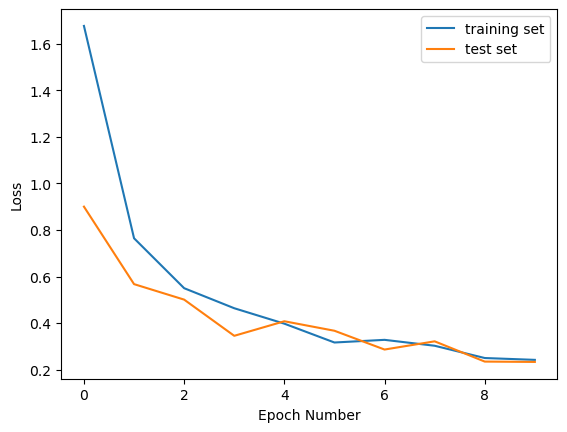

In [14]:
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='training set')
plt.plot(history.history['val_loss'], label='test set')
plt.legend()

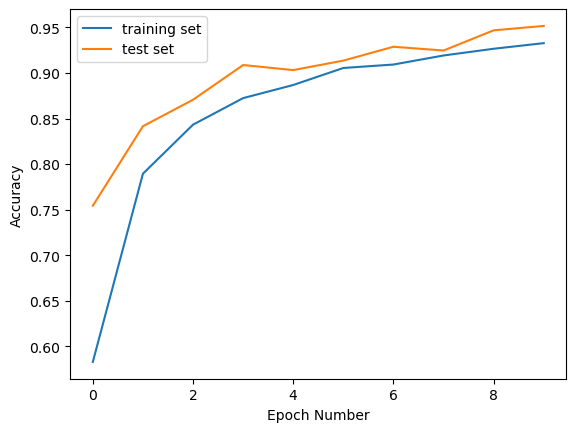

In [15]:
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='training set')
plt.plot(history.history['val_accuracy'], label='test set')
plt.legend()

### saving the model 

In [16]:
model_name = 'weather_image_recognition(inceptionV3).h5'
model.save(model_name, save_format='h5')

In [17]:
class_map = train_data.class_indices
classes = []
for key in class_map.keys():
    classes.append(key)

### image label and prediction and visualization

In [18]:
def predict_image(filename, model):
    img_ = image.load_img(filename, target_size=(228, 228))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0)
    img_processed /= 255.
    
    prediction = model.predict(img_processed)
    
    index = np.argmax(prediction)
    
    plt.title("Prediction - {}".format(str(classes[index]).title()), size=18, color='green')
    plt.imshow(img_array)

1/1 [==============================] - 2s 2s/step


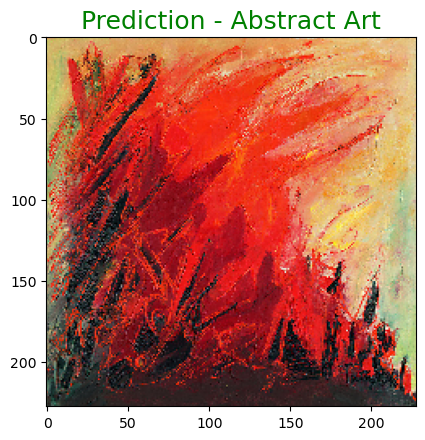

In [36]:
predict_image('/kaggle/input/surreal-symphonies-a-dataset-of-diverse-art/Surreal Symphonies (A dataset of Diverse Artistic Visions)/Abstract art/Abstract art/0mrgszsi.jpg', model)

1/1 [==============================] - 0s 29ms/step


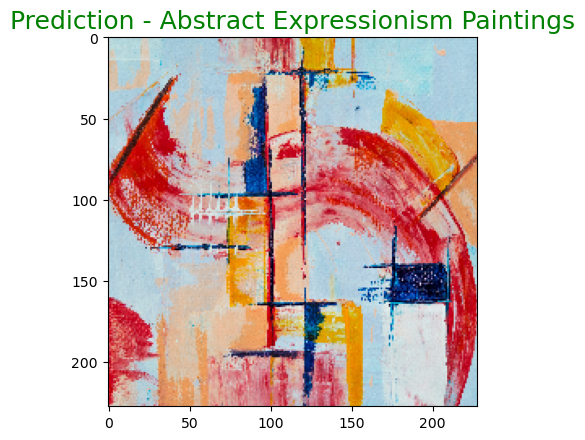

In [37]:
predict_image('/kaggle/input/surreal-symphonies-a-dataset-of-diverse-art/Surreal Symphonies (A dataset of Diverse Artistic Visions)/Abstract expressionism paintings/Abstract expressionism paintings/20wwx98y.jpg', model)

1/1 [==============================] - 0s 29ms/step


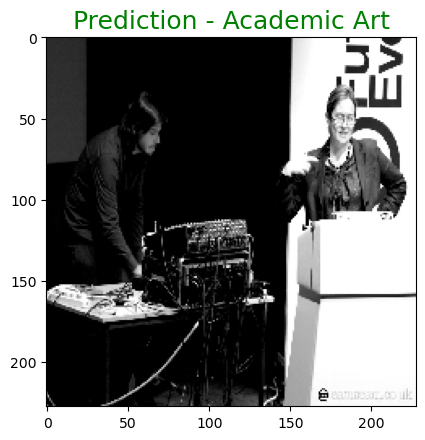

In [38]:
predict_image('/kaggle/input/surreal-symphonies-a-dataset-of-diverse-art/Surreal Symphonies (A dataset of Diverse Artistic Visions)/Academic art/Academic art/13gep9mm.jpg', model)

1/1 [==============================] - 0s 33ms/step


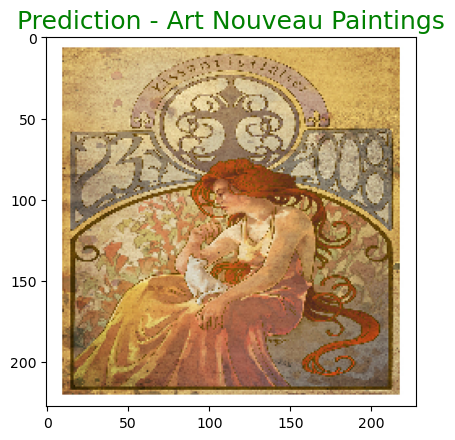

In [39]:
predict_image('/kaggle/input/surreal-symphonies-a-dataset-of-diverse-art/Surreal Symphonies (A dataset of Diverse Artistic Visions)/Art Nouveau paintings/Art Nouveau paintings/1rgnh498.jpg', model)

1/1 [==============================] - 0s 29ms/step


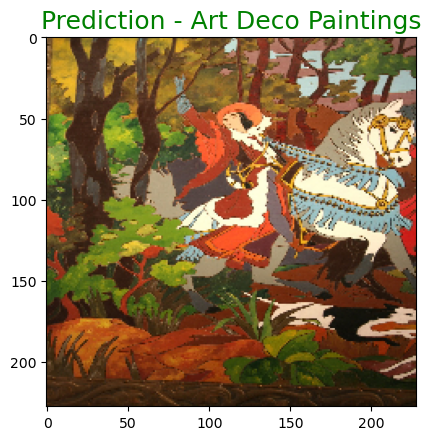

In [40]:
predict_image('/kaggle/input/surreal-symphonies-a-dataset-of-diverse-art/Surreal Symphonies (A dataset of Diverse Artistic Visions)/Art deco paintings/Art deco paintings/6ggh7aek.jpg', model)

### importing libraries for classification report , accuracy score and confusion matrix

In [19]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
# Load the saved model
model = tf.keras.models.load_model('weather_image_recognition(inceptionV3).h5')

# Evaluate the model on the original validation data
val_images, val_labels = next(iter(val_data))
val_predictions = model.predict(val_images)
val_pred_labels = np.argmax(val_predictions, axis=1)
val_true_labels = np.argmax(val_labels, axis=1)


1/1 [==============================] - 1s 1s/step


### f1 score

In [33]:
 # Classification Report
print('Classification Report:')
print(classification_report(val_true_labels, val_pred_labels, zero_division=1))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.67      0.67      0.67         3
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1
          11       0.50      1.00      0.67         1
          12       1.00      1.00      1.00         1
          13       1.00      1.00      1.00         1
          15       1.00      1.00      1.00         1
          16       1.00      1.00      1.00         1
          18       1.00      1.00      1.00         1
          20       1.00      1.00      1.00         2
          21       1.00      1.00      1.00         1
          24       1.00      1.00      1.00         4
    

### accuracy score

In [34]:
# Accuracy Score
accuracy = accuracy_score(val_true_labels, val_pred_labels)
print('Accuracy Score:', accuracy)


Accuracy Score: 0.9375


### confusion matrix

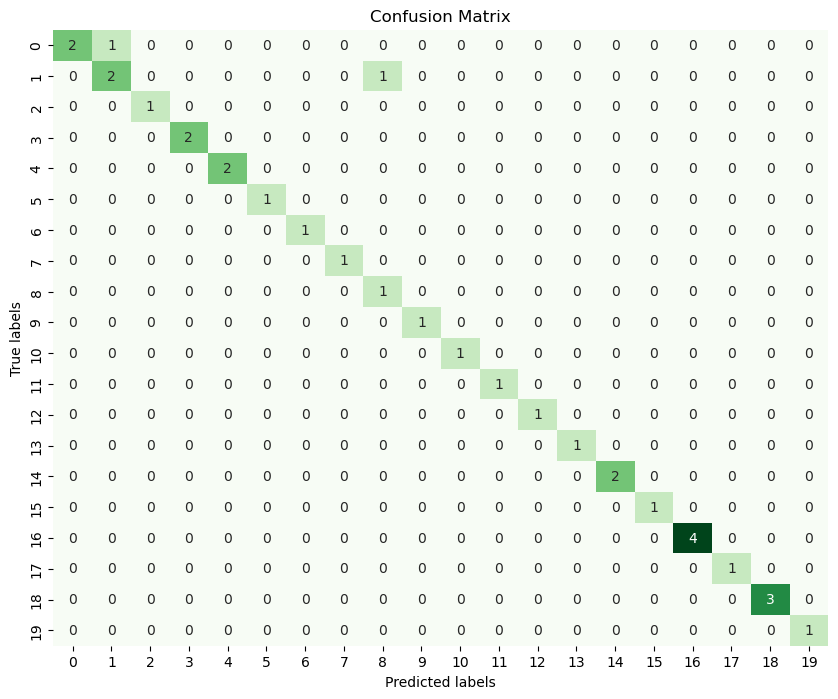

In [35]:
# Confusion Matrix
cm = confusion_matrix(val_true_labels, val_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Greens', fmt='g', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
